# SOME CELL IN THIS NOTE BOOK NEEDS TO BE RUN EACH CELL AT A TIME

Creating the images cell requires the screen to be in the right position


# EDA for Crossroads and Street Segments: MAKE SURE TO LOAD THE NEWEST FILES



In [29]:
import matplotlib.pyplot as plt
import plotly.express as px
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
from IPython.display import Image, display
import leafmap

import time
import pyautogui # for screen shot\

from fpdf import FPDF # Create pdf
from bidi.algorithm import get_display  # for proper RTL ordering
import dataframe_image as dfi # create an image of the dataframe


# for handling files
import glob
import os


### Loading Quarters Data

In [30]:
ta_q = gpd.read_file("./csv_tables/TA_Quaters_UTM/Quarters.shp")
ta_q.oidrova = pd.to_numeric(ta_q.oidrova, downcast='integer')
ta_q.krova = pd.to_numeric(ta_q.krova, downcast='integer')
display(ta_q.crs)
ta_q

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

,oidrova,krova,dateimport,ShapeArea,geometry
0,1,1,01/12/2015 02:28:14,1.301654e+07,"POLYGON ((670795.655 3555762.452, 670797.577 3..."
1,2,2,01/12/2015 02:28:14,8.013404e+06,"POLYGON ((672021.029 3553364.492, 672014.690 3..."
2,3,3,01/12/2015 02:28:14,3.380430e+06,"POLYGON ((668311.070 3552547.701, 668311.229 3..."
3,4,4,01/12/2015 02:28:14,4.510255e+06,"POLYGON ((670771.828 3552544.564, 670771.584 3..."
4,5,6,01/12/2015 02:28:14,2.089044e+06,"POLYGON ((668160.048 3550196.192, 668162.425 3..."
5,6,9,01/12/2015 02:28:14,7.879856e+06,"POLYGON ((668811.121 3546980.368, 668808.698 3..."
6,7,5,01/12/2015 02:28:14,3.024297e+06,"POLYGON ((666698.783 3550619.396, 666701.339 3..."
7,8,8,01/12/2015 02:28:14,3.420996e+06,"POLYGON ((667954.133 3548820.374, 667956.725 3..."
8,9,7,01/12/2015 02:28:14,6.343551e+06,"POLYGON ((665854.540 3548193.053, 665868.137 3..."


#### Plotting Quarters

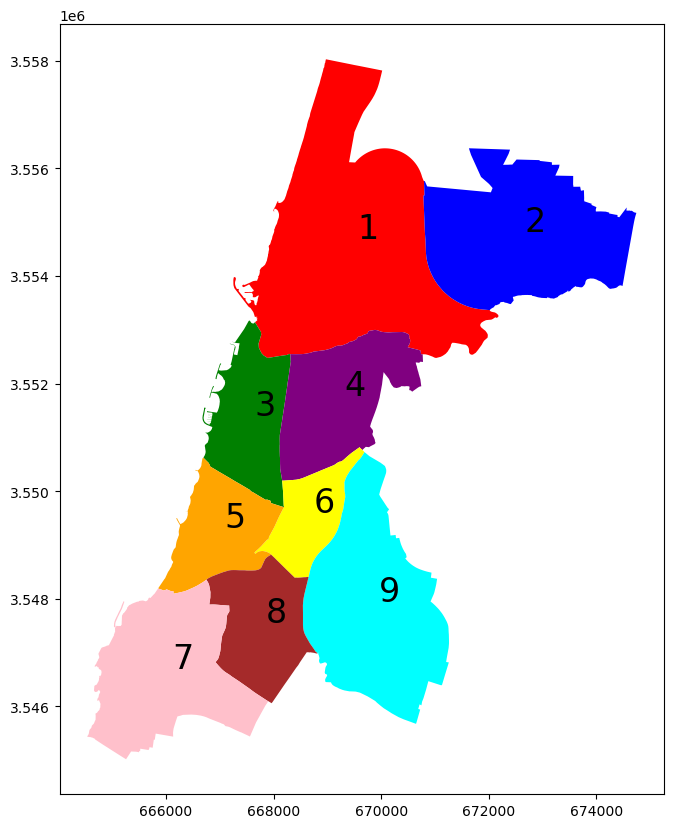

In [31]:
ta_q['index'] = ta_q.index

# Define a list of colors
color_map = {
    1: 'red', 2: 'blue', 3: 'green', 4: 'purple',
    5: 'orange', 6: 'yellow', 7: 'pink', 8: 'brown', 9: 'cyan'
}

# Basic plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each shape with a different color from the list
for idx, row in ta_q.iterrows():
    color = color_map[row['krova']]  # Cycle through the colors list
    gpd.GeoSeries([row['geometry']]).plot(ax=ax, color=color)

    # Get the centroid of the polygon to place the text
    centroid = row['geometry'].centroid
    ax.annotate(text=row['krova'], xy=(centroid.x, centroid.y), 
                xytext=(3, 3), textcoords="offset points",
                fontsize=24, color='black')

plt.show()

### Loading TA Accidents and TA Micro Mobility Accidents

In [32]:
# Exclude micro mobility
BICYCLE = 15
SCOOTER = 21
E_BICYCLE = 23
micro_m = [SCOOTER, E_BICYCLE, BICYCLE]


In [33]:
# Load original accident data
i_m_h_ta_gdf = gpd.read_parquet('./csv_tables/i_m_h_ta_gdf.parquet')

#### Removing 2024 from **i_m_h_ta_gdf**

In [34]:
i_m_h_ta_gdf = i_m_h_ta_gdf[~(i_m_h_ta_gdf.accident_year == 2024)].copy()

In [35]:
# Accidents that are not MM
i_m_h_ta_no_mm_gdf = i_m_h_ta_gdf[~(i_m_h_ta_gdf.involve_vehicle_type.isin(micro_m))].copy()

In [36]:
# Accidents that are just MM
i_m_h_ta_mm_gdf =  gpd.read_parquet('./csv_tables/i_m_h_ta_mm_gdf.parquet')
display(i_m_h_ta_mm_gdf.crs)
i_m_h_ta_mm_gdf.head(5)

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

,accident_id,provider_and_id,provider_code,file_type_police,involved_type,involved_type_hebrew,license_acquiring_date,age_group,age_group_hebrew,sex,...,vehicle_attribution,vehicle_attribution_hebrew,seats,total_weight,total_weight_hebrew,vehicle_damage,vehicle_damage_hebrew,urban_intersection,accident_date,geometry
41,2013001368,32013001368,3,3,2,נהג נפגע,0,6,25-29,1,...,1.0,ישראלי,99.0,0.0,לא ידוע,4.0,אין נזק,NaN,2013-07-27 01:00:00,POINT (667544.749 3549959.961)
50,2013001742,32013001742,3,3,2,נהג נפגע,0,7,30-34,2,...,1.0,ישראלי,99.0,0.0,לא ידוע,4.0,אין נזק,NaN,2013-10-07 01:30:00,POINT (667286.918 3548726.540)
131,2013001350,12013001350,1,1,2,נהג נפגע,0,5,20-24,1,...,1.0,ישראלי,99.0,0.0,לא ידוע,4.0,אין נזק,NaN,2013-08-25 01:00:00,POINT (667023.688 3548785.170)
196,2013000147,12013000147,1,1,2,נהג נפגע,0,8,35-39,1,...,1.0,ישראלי,99.0,0.0,לא ידוע,2.0,בינוני,9110323.0,2013-09-19 00:00:00,POINT (668158.751 3551284.678)
197,2013000147,12013000147,1,1,2,נהג נפגע,0,6,25-29,1,...,1.0,ישראלי,99.0,0.0,לא ידוע,2.0,בינוני,9110323.0,2013-09-19 00:00:00,POINT (668158.751 3551284.678)


#### Plotting accidents

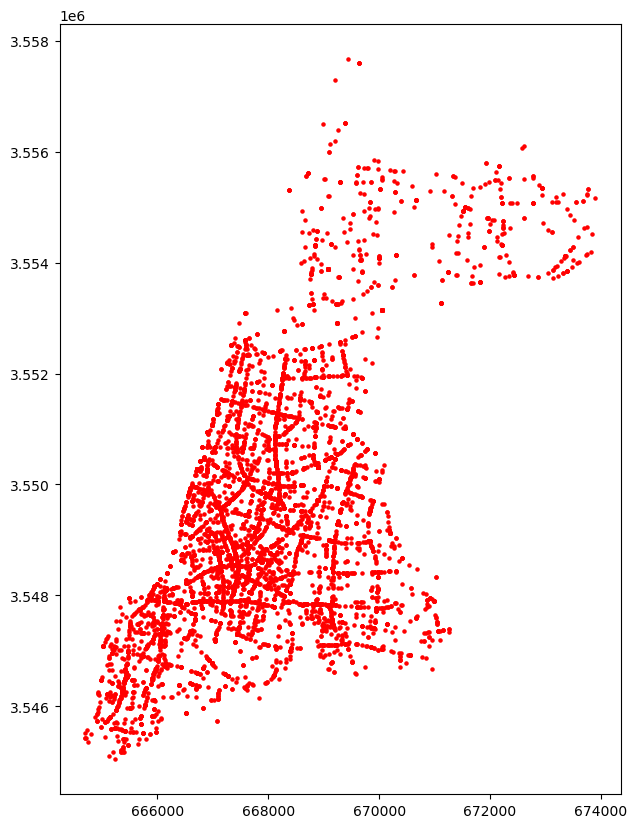

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )
plt.show()

### Loading BP

In [38]:
bp_ta_bp_and_meta = gpd.read_parquet('./csv_tables/bp_ta_bp_and_meta.parquet')
display(bp_ta_bp_and_meta.head(5)), bp_ta_bp_and_meta.shape

,oid_shvil,msorech,dateimport,create_year,shemmikta,create_date,geometry,width,direction,bitzua,miflas,date_created
0,1,95.10,14/08/2024 02:30:05,2012,נמיר מיוניצ'מן דרומה,None,"LINESTRING (669823.985 3557373.860, 669855.549...",2.5,דו סטרי,2012,None,None
1,2,201.14,14/08/2024 02:30:05,2013,פרופס מנמיר עד קדושי השואה,None,"LINESTRING (669232.834 3555478.027, 669169.381...",2.5,דו סטרי,2013,None,None
2,3,696.31,14/08/2024 02:30:05,2004,יאיר רוזנבלום מאורי צבי גרינברג עד פרופס,None,"LINESTRING (669232.637 3555478.023, 669249.025...",2.1,דו סטרי,2004,None,None
3,4,659.20,14/08/2024 02:30:05,2018,"קק""ל מנמיר עד חיים לבנון",None,"LINESTRING (669354.261 3555417.055, 669410.178...",2.5,דו סטרי,2018,מדרכה,None
4,5,362.67,14/08/2024 02:30:05,2018,רקנאטי בגינה מקרן קיימת לישראל עד אחימאיר,None,"LINESTRING (669946.350 3555344.516, 669962.261...",2.0,דו סטרי,2018,None,30/06/2018


(None, (871, 12))

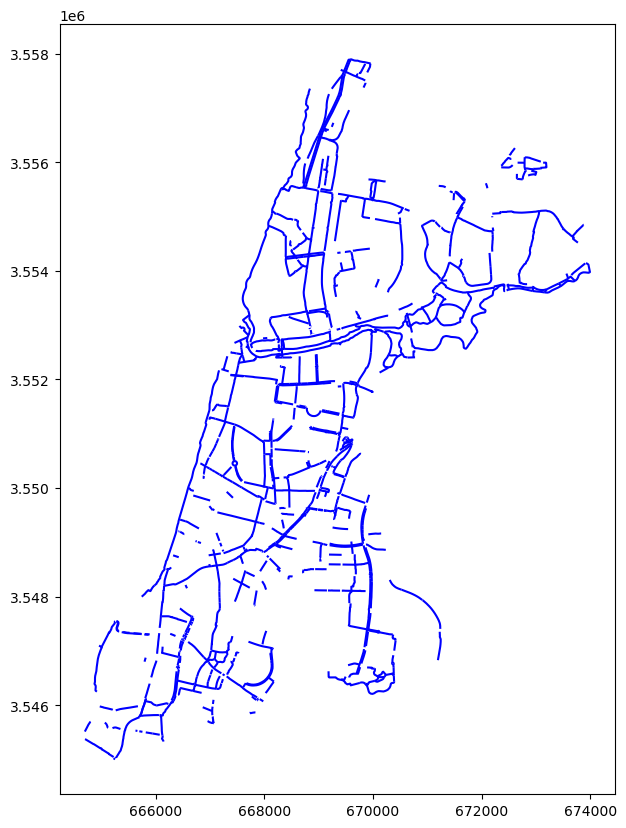

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
bp_ta_bp_and_meta.plot(ax=ax, color='blue' )
plt.show()

#### Checking validity by lotting Quarters, Micro Mobility Accidents  and BP

In [40]:
i_m_h_ta_mm_gdf.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Plotting accidents with BP and Quarters

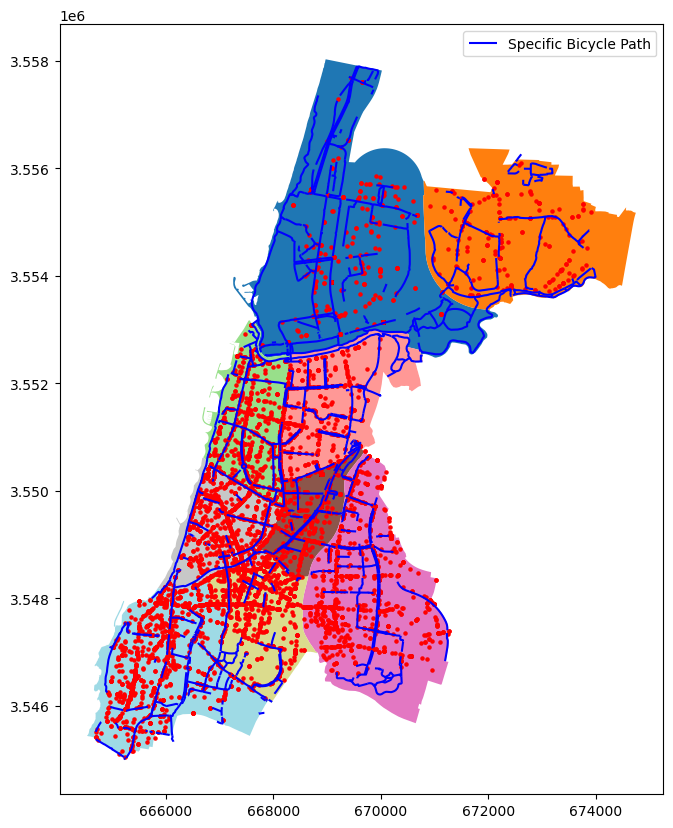

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))

ta_q.plot(ax=ax, cmap='tab20', legend=True,)
bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )

plt.legend()
plt.show()

## Loading streets data


In [42]:
ta_streets = gpd.read_parquet('./csv_tables/ta_street_corrected.parquet')
ta_streets

,oidrechov,krechov,trechov,shemangli,mslamas,tsug,kkivun,UniqueId,shemarvit,kreka,geometry
0,1.0,915.0,הרוגי מלכות,HARUGEY MALKHOT,336.0,רחוב,0.0,507-10001,قتل مملكة,100.0,"LINESTRING (672865.880 3554095.253, 672895.216..."
1,2.0,0.0,0,UKNOWN,0.0,רחוב,3.0,507-10002,None,100.0,"LINESTRING (666990.498 3551436.940, 667065.337..."
2,3.0,265.0,אמסטרדם,AMSTERDAM,516.0,רחוב,1.0,507-10003,أمستردام,100.0,"LINESTRING (667879.712 3551424.162, 667940.741..."
3,4.0,644.0,אלון יגאל,YIG'AL ALLON,2524.0,רחוב,0.0,507-10004,ألون ييغال,200.0,"LINESTRING (669570.036 3550420.535, 669581.404..."
4,5.0,634.0,מרגולין,MARGOLIN,2649.0,רחוב,1.0,507-10005,مارغولين,100.0,"LINESTRING (669329.153 3548322.758, 669409.403..."
...,...,...,...,...,...,...,...,...,...,...,...
8874,9851.0,3007.0,שבטי ישראל,SHIVTEY YISRA'EL,1983.0,רחוב,0.0,507-17843,قبائل إسرائيل,100.0,"LINESTRING (665771.816 3547023.159, 665760.256..."
8875,9852.0,3058.0,אבינרי יצחק,AVINERY,2027.0,רחוב,0.0,507-20562,Avinri Yitzhak,100.0,"LINESTRING (665585.719 3547178.152, 665627.936..."
8876,9853.0,3058.0,אבינרי יצחק,AVINERY,2027.0,רחוב,0.0,507-20563,Avinri Yitzhak,100.0,"LINESTRING (665700.142 3547064.296, 665759.119..."
8877,9855.0,3907.0,3907,None,1703.0,רחוב,0.0,507-21960,3907,100.0,"LINESTRING (665087.059 3546677.092, 665075.120..."


#### Checking street length validity with google maps

In [43]:
ta_streets[ta_streets.shemangli == 'MARGOLIN'].geometry.length.sum()

690.5226685950398

#### Plotting streets with BP and MM Accidents and  Quarters

In [44]:

# fig, ax = plt.subplots(figsize=(30, 30))

# ta_streets.plot(ax=ax, cmap='tab20', legend=True, label='Specific Bicycle Path')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_mm_gdf.plot(ax=ax, color='black', marker='o', markersize=15 )


# plt.legend()
# plt.show()

Checking Location Accuracy

In [45]:
i_m_h_ta_gdf.location_accuracy.value_counts(normalize=True)

location_accuracy
1    0.510117
3    0.425593
2    0.064290
Name: proportion, dtype: float64

In [46]:
i_m_h_ta_mm_gdf.location_accuracy.value_counts(normalize=True)

location_accuracy
1    0.597338
3    0.379679
2    0.022983
Name: proportion, dtype: float64

In [47]:
i_m_h_ta_mm_gdf[i_m_h_ta_mm_gdf.accident_year.isin([2018,2019,2020,2021,2022,2023])].location_accuracy.value_counts(normalize=True)

location_accuracy
1    0.644453
3    0.335212
2    0.020334
Name: proportion, dtype: float64

1 = accurate coordinates<br>
2 = city center <br>
3 = street center

What we care is if the accident is accurate or if the accident is in the street center, why?

If the accident is in it's actual coordinates or if it's in the street center then that means it's in the quarter.

But a street can extend outside the quarter, so I need to make sure how many street intersect other quarters.

Currently I want to check street in 2 = city center, and will probably drop them.

In [48]:
i_m_h_ta_gdf[i_m_h_ta_gdf.location_accuracy == 2].x.value_counts()

x
180245.0    3094
180264.0    2296
180276.0    1265
178125.0      62
182556.0      55
184617.0      39
181651.0      21
181256.0      18
180108.0      16
184141.0      14
177917.0      13
179039.0      12
180029.0      10
182785.0       9
185394.0       9
184741.0       8
181582.0       6
178949.0       6
180697.0       6
178005.0       5
180219.0       5
184435.0       5
180560.0       3
183426.0       3
181104.0       3
181130.0       2
180368.0       1
181509.0       1
Name: count, dtype: int64

In [49]:
i_m_h_ta_gdf.shape

(108679, 162)

We should drop **location_accuracy** 2

---

Lets check **location_accuracy** 3

In [50]:
i_m_h_ta_gdf = i_m_h_ta_gdf[~(i_m_h_ta_gdf.location_accuracy == 2)].copy()
i_m_h_ta_gdf.shape

(101692, 162)

In [51]:
# fig, ax = plt.subplots(figsize=(30, 30))

# ta_streets.plot(ax=ax, cmap='tab20', legend=True, label='Specific Bicycle Path')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_gdf[i_m_h_ta_gdf.location_accuracy == 2].plot(ax=ax, color='black', marker='o', markersize=15 )


# plt.legend()
# plt.show()

#### Drop street in ta_streets with these names:

These streets were checked in **00_B_checking_streets_on_map.ipynb** and found to be not actually connected to streets.

* ו'
* ח'
* _*_
* 0
 

In [52]:
ta_streets = ta_streets[~ta_streets.trechov.isin(["ו'","ח'","*", "0"])].copy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


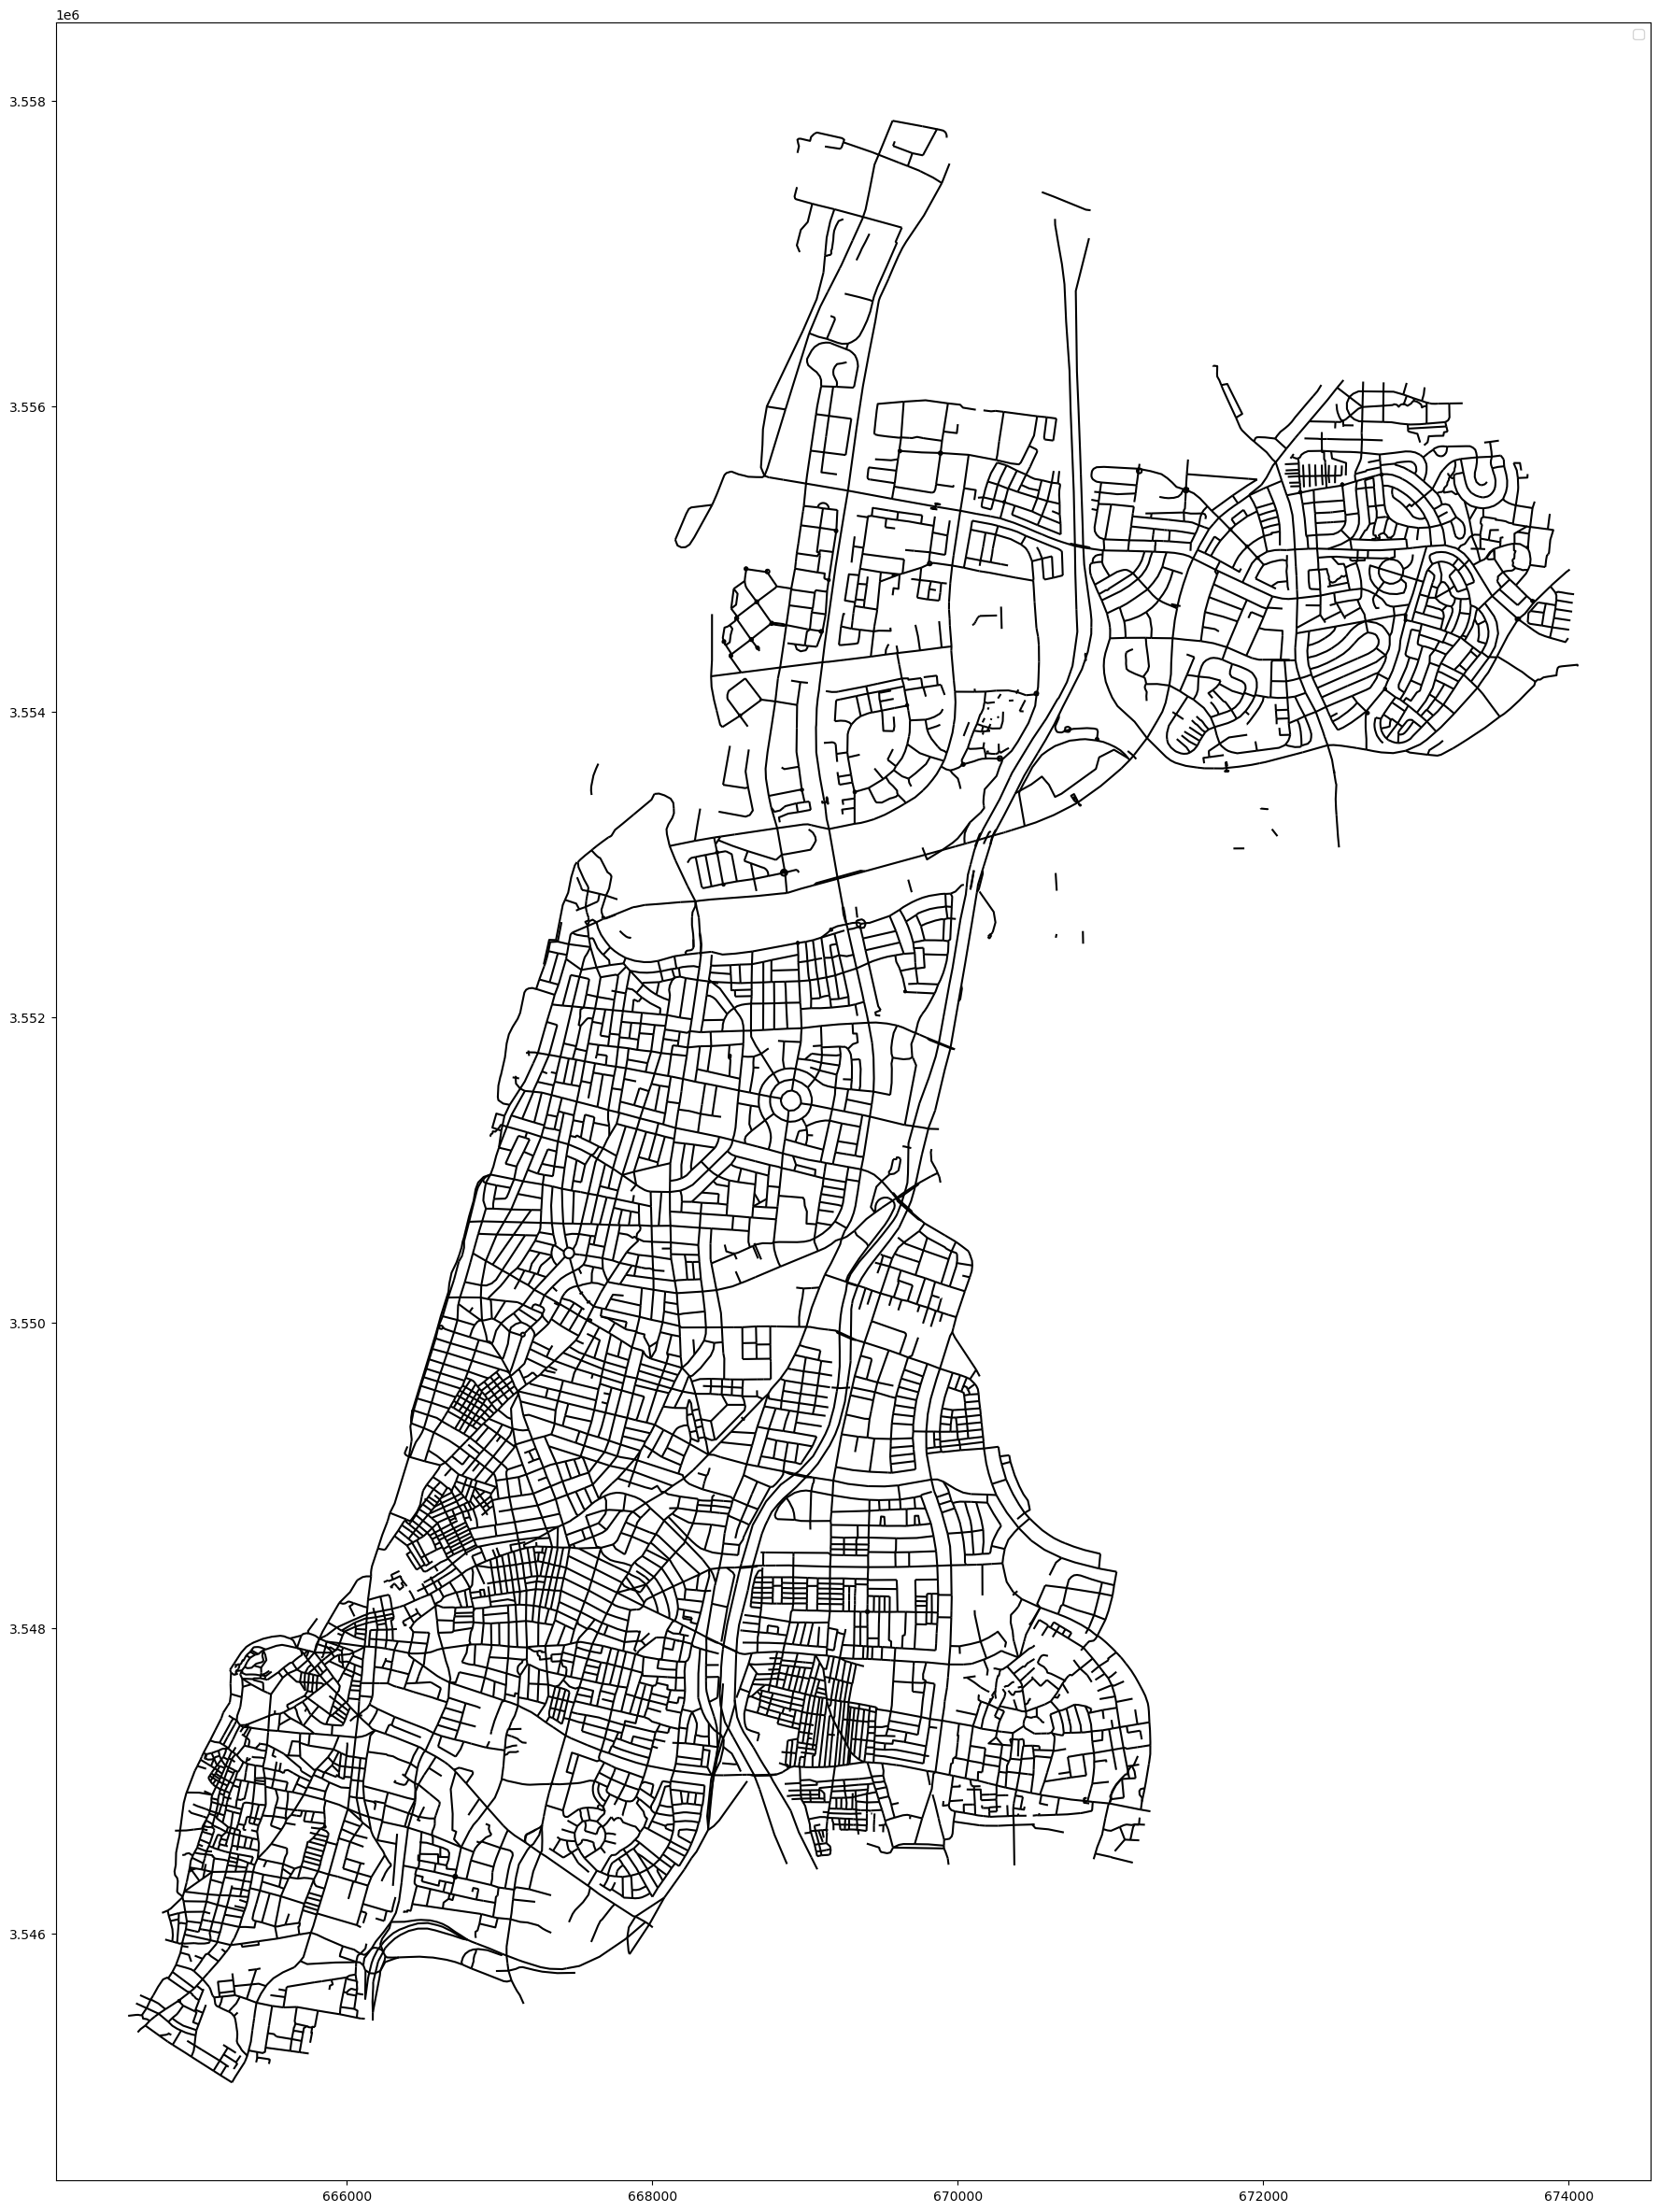

In [53]:
fig, ax = plt.subplots(figsize=(30, 30))

ta_streets.plot(ax=ax, color='black')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_gdf[i_m_h_ta_gdf.location_accuracy == 3].plot(ax=ax, color='black', marker='o', markersize=15 )


plt.legend()
plt.show()

#### Plotting functions

In [54]:
import matplotlib.pyplot as plt

def plot_bar_chart(x_data, y_data, title, x_label, y_label, decimal_places=2):
    # Ensure data is in a form that can be indexed by integer
    if not isinstance(x_data, (list, tuple)):
        x_data = list(x_data)
    if not isinstance(y_data, (list, tuple)):
        y_data = list(y_data)

    x_positions = range(len(x_data))

    # Increase figure size if needed for long labels
    plt.figure(figsize=(10, 6))

    bars = plt.bar(x_positions, y_data, color='blue')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add the value above each bar
    for i, bar in enumerate(bars):
        yval = round(y_data[i], decimal_places)
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height(), 
            str(yval),
            ha='center', 
            va='bottom'
        )

    # Rotate the x-axis labels
    plt.xticks(x_positions, x_data, rotation=45, ha='right')

    # Adjust layout so labels are not cut off
    plt.tight_layout()
    plt.show()


In [55]:
import plotly.graph_objects as go

def plot_bar_chart_heb(x_data, y_data, title, x_label, y_label, decimal_places=2):
    """
    Plots a bar chart using Plotly with optional rotation for Hebrew (or long) x-axis labels.
    
    :param x_data: List of labels or categories for the x-axis (e.g., Hebrew strings)
    :param y_data: List of numeric values for the y-axis
    :param title:  Title of the chart
    :param x_label: Label for the x-axis
    :param y_label: Label for the y-axis
    :param decimal_places: Number of decimal places to display above each bar
    """
    # Create the bar trace (each bar) with text above them showing the numeric value
    fig = go.Figure(
        data=[
            go.Bar(
                x=x_data,
                y=y_data,
                text=[f"{round(val, decimal_places)}" for val in y_data],
                textposition='auto'  # 'auto' puts the label above or inside the bar depending on space
            )
        ]
    )
    
    # Update the layout to set title, axes labels, and tilt (rotate) x-axis labels
    fig.update_layout(
        title={
            'text': title,
            'x': 0.5  # Centers the title
        },
        xaxis={
            'title': x_label,
            'tickangle': -45  # Rotates labels by -45 degrees
        },
        yaxis={'title': y_label},
        margin=dict(l=50, r=50, t=80, b=80)  # Adjust margins if needed
    )
    
    # Show the figure
    fig.show()


In [56]:
def plot_bar_chart_2(x_data, y_data1, y_data2, title, x_label, y_label, y_data1_label='data set 1', y_data2_label='data set 2', decimal_places=2):
    """
    Plot a bar chart with two bars for each x-tick.

    Parameters:
    - x_data (list or array): The data for the x-axis.
    - y_data1 (list or array): The data for the first set of bars.
    - y_data2 (list or array): The data for the second set of bars.
    - title (str): The title of the plot.
    - x_label (str): The label for the x-axis.
    - y_label (str): The label for the y-axis.
    - y_data1_label (str): The legend label for the first dataset.
    - y_data2_label (str): The legend label for the second dataset.
    - decimal_places (int): Decimal places to round the values shown on top of bars.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Ensure data is in a form that can be indexed by integer
    if not isinstance(x_data, (list, tuple)):
        x_data = list(x_data)
    if not isinstance(y_data1, (list, tuple)):
        y_data1 = list(y_data1)
    if not isinstance(y_data2, (list, tuple)):
        y_data2 = list(y_data2)

    plt.figure(figsize=(8, 6))
    bar_width = 0.35
    x = np.arange(len(x_data))
    
    # Plot bars with a slight offset to create a gap
    bars1 = plt.bar(x - bar_width*0.6, y_data1, bar_width, color='blue', label=y_data1_label)
    bars2 = plt.bar(x + bar_width*0.6, y_data2, bar_width, color='red', label=y_data2_label)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add the value above each bar
    for bars, y_values in [(bars1, y_data1), (bars2, y_data2)]:
        for bar, yval in zip(bars, y_values):
            yval_rounded = round(yval, decimal_places)
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                     str(yval_rounded), ha='center', va='bottom')

    # Set x-ticks to match the x_data labels
    plt.xticks(x, x_data)

    plt.legend(title='Legend')
    plt.tight_layout()
    plt.show()


## Accidents numbers in crossroads and streets between them

In [57]:
ta_crossroads = gpd.read_parquet('./csv_tables/ta_crossroads_26012025.parquet')
ta_crossroads.shape

(3526, 8)

In [58]:
ta_streets_no_cr_poly = gpd.read_parquet('./csv_tables/ta_streets_no_cr_poly_26012025.parquet')
ta_streets_no_cr_poly.shape

(6114, 26)

In [59]:
# Accidents that are 
i_m_h_ta_no_scooter_gdf = i_m_h_ta_gdf[(i_m_h_ta_gdf.involve_vehicle_type == SCOOTER) & (i_m_h_ta_gdf.location_accuracy != 2) ].copy()
i_m_h_ta_no_scooter_gdf.shape

(1924, 162)

In [60]:
# FOLDERS

# ALL ACCIDENTS
ALL_ACCIDENTS_CR_CNT_PATH   = './csv_tables/images_all_accidents/crossroads_count'
ALL_ACCIDENTS_SG_CNT_PATH   = './csv_tables/images_all_accidents/streets_count'
ALL_ACCIDENTS_SG_RATIO_PATH = './csv_tables/images_all_accidents/streets_ratio'

# SEVER ACCIDENTS
SEVERE_ACCIDENTS_CR_CNT_PATH   = './csv_tables/images_severe_accidents/crossroads_count'
SEVERE_ACCIDENTS_SG_CNT_PATH   = './csv_tables/images_severe_accidents/streets_count'
SEVERE_ACCIDENTS_SG_RATIO_PATH = './csv_tables/images_severe_accidents/streets_ratio'

# KILLED ACCIDENTS
KILLED_ACCIDENTS_CR_CNT_PATH   = './csv_tables/images_killed_accidents/crossroads_count'
KILLED_ACCIDENTS_SG_CNT_PATH   = './csv_tables/images_killed_accidents/streets_count'
KILLED_ACCIDENTS_SG_RATIO_PATH = './csv_tables/images_killed_accidents/streets_ratio'

# MM ACCIDENTS
MM_ACCIDENTS_CR_CNT_PATH   = './csv_tables/images_mm_accidents/crossroads_count'
MM_ACCIDENTS_SG_CNT_PATH   = './csv_tables/images_mm_accidents/streets_count'
MM_ACCIDENTS_SG_RATIO_PATH = './csv_tables/images_mm_accidents/streets_ratio'

# SCOOTER ACCIDENTS
SCOOTER_ACCIDENTS_CR_CNT_PATH   = './csv_tables/images_scooter_accidents/crossroads_count'
SCOOTER_ACCIDENTS_SG_CNT_PATH   = './csv_tables/images_scooter_accidents/streets_count'
SCOOTER_ACCIDENTS_SG_RATIO_PATH = './csv_tables/images_scooter_accidents/streets_ratio'

#### Helper function

In [61]:

def process_accidents_data(
    accidents_gdf: gpd.GeoDataFrame,
    ta_crossroads: gpd.GeoDataFrame,
    ta_streets_no_cr_poly: gpd.GeoDataFrame,
    buffer_accidents: float = 4.0,
):
    """
    Identifies accidents accidents that happened at crossroads and on street segments, 
    drops duplicates, and removes those accidents at crossroads from street segments.

    Parameters
    ----------
    accidents_gdf : gpd.GeoDataFrame
        The GeoDataFrame containing accidents accident data (or the accident data of choice).
    ta_crossroads : gpd.GeoDataFrame
        The GeoDataFrame containing crossroad geometries.
    ta_streets_no_cr_poly : gpd.GeoDataFrame
        The GeoDataFrame containing street segment geometries (excluding crossroads).
    buffer_accidents : float, optional
        The buffer distance applied to accident points when intersecting with crossroads. 
        Defaults to 4.0.

    Returns
    -------
    tuple
        A 4-tuple of GeoDataFrames:
        (
            ta_cr_sjoin_accidents,  # Crossroads joined with accidents 
            accidents_on_cr,     # Accidents at crossroads 
            streets_seg_sjoin_accidents,  # Street segments joined with accidents
            accidents_on_st_seg       # Accidents on street segments (excluding crossroads)
        )
    """
    
    # 1. Copy the accident GeoDataFrame so we don't alter the original
    accidents_gdf_cp = accidents_gdf.copy()
    
    # 2. Apply buffer for crossroad analysis
    accidents_gdf_cp.geometry = accidents_gdf_cp.buffer(buffer_accidents)
    
    # 3. Spatial join: Crossroads with accidents
    ta_cr_sjoin_accidents = gpd.sjoin(
        ta_crossroads, 
        accidents_gdf_cp, 
        how='inner', 
        predicate='intersects'
    )
    accidents_on_cr = gpd.sjoin(
        accidents_gdf_cp, 
        ta_crossroads, 
        how='inner', 
        predicate='intersects'
    )
    
    # Print shape before dropping duplicates
    ta_cr_sjoin_accidents = ta_cr_sjoin_accidents.drop_duplicates(subset='cr_idx')
    print('Crossroads where accidents happened:', ta_cr_sjoin_accidents.shape)
    
    accidents_on_cr = accidents_on_cr.drop_duplicates(subset='provider_and_id')
    print('Accidents on crossroads:', accidents_on_cr.shape, '\n')
    
    # 4. Spatial join: Street segments with accidents
    streets_seg_sjoin_accidents = gpd.sjoin(
        ta_streets_no_cr_poly, 
        accidents_gdf_cp, 
        how='inner', 
        predicate='intersects'
    )
    accidents_on_st_seg = gpd.sjoin(
        accidents_gdf_cp, 
        ta_streets_no_cr_poly, 
        how='inner', 
        predicate='intersects'
    )

    
    streets_seg_sjoin_accidents = streets_seg_sjoin_accidents.drop_duplicates(subset='st_seg_idx')
    print('Street segments that accidents happened:', streets_seg_sjoin_accidents.shape)
    
    accidents_on_st_seg = accidents_on_st_seg.drop_duplicates(subset='provider_and_id')
    
    # 6. Remove accidents that already appear in crossroads from the street-segments layer
    accidents_on_st_seg = accidents_on_st_seg[
        ~accidents_on_st_seg.provider_and_id.isin(accidents_on_cr.provider_and_id)
    ]

    accidents_no_cr_or_seg = accidents_gdf_cp[(~accidents_gdf_cp.provider_and_id.isin(accidents_on_cr.provider_and_id)) & 
                        (~accidents_gdf_cp.provider_and_id.isin(accidents_on_st_seg.provider_and_id))]
    
    print('Accidents on street segments (excluding crossroads):', accidents_on_st_seg.shape,'\n')

    print('Accidents that are not on streets or crossroads:', accidents_no_cr_or_seg.shape)
    
    # Return the relevant GeoDataFrames
    return (
        ta_cr_sjoin_accidents,   # Crossroads joined with accidents
        accidents_on_cr,      # Accidents at crossroads
        streets_seg_sjoin_accidents,  # Street segments joined with accidents
        accidents_on_st_seg,   # Accidents on street segments (excluding crossroads)
        accidents_no_cr_or_seg # Accidents that are not on streets or crossroads
    )


In [62]:
import plotly.graph_objs as go

def plot_separate_lines_by_sorted_count(
    df,
    top_10_by_cnt,
    x_col='accident_year',
    y_col='acc_count',
    group_col='cr_idx',
    label_col='cr_name',
    title_prefix="Crossroad Plot: ",
    width=1000,
    height=600
):
    """
    Creates one Plotly line chart per crossroad, iterating in the order given by
    top_10_by_cnt.index (already sorted by accident count).

    Parameters
    ----------
    df : pd.DataFrame
        A preprocessed DataFrame containing (at least) the columns for x_col, y_col, group_col, and label_col.
        Example columns: ['accident_year', 'acc_count', 'cr_idx', 'cr_name'].
    top_10_by_cnt : pd.DataFrame or pd.Series
        A DataFrame or Series where the index is 'cr_idx', sorted by some criterion (e.g., descending count).
        We will iterate over this index in order to plot each crossroad's figure.
    x_col : str, default 'accident_year'
        The column used on the x-axis.
    y_col : str, default 'acc_count'
        The column used on the y-axis.
    group_col : str, default 'cr_idx'
        The column identifying different crossroads (groups).
    label_col : str, default 'cr_name'
        The column for labeling each group in the figure title.
    title_prefix : str, default "Crossroad Plot: "
        A prefix for each figure's title, e.g., "Crossroad Plot: King & Main".
    width : int, default 1000
        Figure width in pixels.
    height : int, default 600
        Figure height in pixels.

    Returns
    -------
    dict
        A dictionary where each key is a crossroad id (from top_10_by_cnt.index),
        and each value is a Plotly Figure object.

    Example
    -------
    # Suppose df_yearly_counts is your DataFrame with columns: 'accident_year', 'cr_idx', 'acc_count'
    # and you've merged in 'cr_name'. Also suppose top_10_by_cnt has cr_idx as its index.
    
    figures_dict = plot_separate_lines_by_sorted_count(
        df=df_yearly_counts,
        top_10_by_cnt=top_10_by_cnt,
        x_col='accident_year',
        y_col='acc_count',
        group_col='cr_idx',
        label_col='cr_name',
        title_prefix="Accidents for Crossroad: "
    )
    
    # Show each figure
    for cr_idx_val, fig in figures_dict.items():
        fig.show()
    """

    # A dictionary to store figures keyed by crossroad (cr_idx)
    figures = {}

    # The crossroads in the order of their sorted counts
    sorted_groups = top_10_by_cnt.index

    for grp_val in sorted_groups:
        # Subset df to just this crossroad, then sort by x_col
        grp_df = df[df[group_col] == grp_val].sort_values(by=x_col)
        
        if grp_df.empty:
            # It's possible that top_10_by_cnt includes a cr_idx
            # that doesn't appear in df (rare, but can happen). Skip if empty.
            continue
        
        # Retrieve a label for the figure title (e.g., "Main & King")
        label_series = grp_df[label_col].dropna()
        if not label_series.empty:
            label_for_title = label_series.iloc[0]
        else:
            label_for_title = str(grp_val)

        # Create a new figure for this crossroad
        fig = go.Figure()

        # Add a single line trace
        fig.add_trace(
            go.Scatter(
                x=grp_df[x_col],
                y=grp_df[y_col],
                mode='lines+markers',
                name=label_for_title
            )
        )

        # Customize layout
        fig.update_layout(
            title=f"{title_prefix}{label_for_title}",
            xaxis_title=x_col,
            yaxis_title=y_col,
            width=width,
            height=height
        )

        # Store the figure under the crossroad's ID
        figures[grp_val] = fig

    return figures


In [63]:
def plot_accidents_on_map(
    crossroads_joined_accidents: gpd.GeoDataFrame,
    accidents_on_crossroads: gpd.GeoDataFrame,
    streets_joined_accidents: gpd.GeoDataFrame,
    accidents_on_streets: gpd.GeoDataFrame,
    accidents_elsewhere: gpd.GeoDataFrame,
    center: tuple = (32.047, 34.785),
    zoom: int = 11
) -> leafmap.Map:
    """
    Plots different categories of accidents on a Leafmap map.

    Parameters
    ----------
    crossroads_joined_accidents : gpd.GeoDataFrame
        GeoDataFrame representing crossroads features joined with accidents.
        Example: the result of a spatial join between crossroads polygons 
        and accident points.
    accidents_on_crossroads : gpd.GeoDataFrame
        GeoDataFrame representing the actual accident points located on crossroads.
    streets_joined_accidents : gpd.GeoDataFrame
        GeoDataFrame representing street-segment features joined with accidents.
        Example: the result of a spatial join between street segment polygons 
        and accident points.
    accidents_on_streets : gpd.GeoDataFrame
        GeoDataFrame representing the actual accident points located on street segments.
    accidents_elsewhere : gpd.GeoDataFrame
        GeoDataFrame representing accident points not on crossroads or street segments.
    center : tuple, optional
        Tuple of latitude and longitude to define the map center. 
        Defaults to (32.047, 34.785).
    zoom : int, optional
        Initial zoom level of the map. Defaults to 11.

    Returns
    -------
    leafmap.Map
        A Leafmap map object with the provided GeoDataFrames overlaid.
    """

    # Create the Leafmap
    m = leafmap.Map(center=center, zoom=zoom)
    
    # Crossroads and accidents on crossroads
    m.add_gdf(
        crossroads_joined_accidents,
        style={
            "color": "green",
            "weight": 3,
            "opacity": 0.7,
            "fillColor": "green",
            "fillOpacity": 0.3,
        },
    )
    m.add_gdf(
        accidents_on_crossroads,
        style={
            "color": "green",
            "weight": 3,
            "opacity": 1,
            "fillColor": "green",
            "fillOpacity": 0.3,
        },
    )

    # Street segments and accidents on street segments
    m.add_gdf(
        streets_joined_accidents,
        style={
            "color": "blue",
            "weight": 3,
            "opacity": 0.7,
            "fillColor": "blue",
            "fillOpacity": 0.3,
        },
    )
    m.add_gdf(
        accidents_on_streets,
        style={
            "color": "blue",
            "weight": 3,
            "opacity": 1,
            "fillColor": "blue",
            "fillOpacity": 0.3,
        },
    )

    # Accidents not on crossroads or street segments
    m.add_gdf(
        accidents_elsewhere,
        style={
            "color": "red",
            "weight": 3,
            "opacity": 0.7,
            "fillColor": "red",
            "fillOpacity": 0.3,
        },
    )

    return m


In [64]:
import os
import time
import pyautogui
import geopandas as gpd

def recenter_and_screenshot(
    m,
    gdf,
    crs="EPSG:32636",
    zoom=12,
    screenshot_prefix="screenshot_",
    output_dir="."
):
    """
    Iterates over the centroids of a GeoDataFrame, recenters the map on each centroid,
    waits, and takes a screenshot.

    Parameters
    ----------
    m : leafmap.Map
        The leafmap map instance that has already been displayed.
    gdf : GeoDataFrame
        A GeoDataFrame containing polygons (or any geometry). Assumes it is in `crs` (default EPSG:32636).
    crs : str, optional
        The current CRS of `gdf`. Default is "EPSG:32636".
    zoom : int, optional
        Zoom level to use when recentering. Default is 12.
    screenshot_prefix : str, optional
        Filename prefix for the screenshots. Default is "screenshot_".
    output_dir : str, optional
        Directory where screenshots will be saved. Default is the current directory (".").

    Returns
    -------
    None
    """

    # 1) Compute centroid in the given CRS (default EPSG:32636)
    centroids_utm = gdf.geometry.centroid

    # 2) Build a GeoDataFrame from those centroids to reproject to EPSG:4326
    centroids_gdf = gpd.GeoDataFrame(geometry=centroids_utm, crs=crs)
    centroids_wgs84 = centroids_gdf.to_crs("EPSG:4326")

    # Make sure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # 3) Iterate over the centroids
    for i, point in enumerate(centroids_wgs84.geometry):
        lon, lat = point.x, point.y

        # Recenter the map
        m.set_center(lat=lat, lon=lon, zoom=zoom)

        # Wait 3 seconds to allow the map to render
        time.sleep(3)

        # Capture a screenshot of the *entire screen* or a specified region
        screenshot = pyautogui.screenshot(region=(450, 270, 2000, 1050))
        
        # Build the full path to save the screenshot
        filename = f"{screenshot_prefix}{i}.png"
        filepath = os.path.join(output_dir, filename)
        
        # Save the screenshot
        screenshot.save(filepath)

        # Wait 2 more seconds before moving to the next centroid
        time.sleep(2)


In [66]:
def df_and_images_to_pdf_hebrew(
    df, 
    images_folder, 
    columns=None, 
    output_pdf="output.pdf"
):
    """
    Creates a PDF where:
      (1) A "0_table.png" is created from the given DataFrame (styled, right-aligned).
          This image is placed on the first page.
      (2) Then, for each row in the DataFrame, a new page is created with:
          - The row's text (in Hebrew-friendly, RTL formatting)
          - The next image in the folder, sorted alphabetically.
      
    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data to display as text.

    images_folder : str
        The path to the folder that contains PNG images. Images are sorted alphabetically.

    columns : list of str, optional
        The columns of the DataFrame to show. If None or empty, uses all columns of `df`.

    output_pdf : str, optional
        The path (including filename) where the PDF will be saved. Defaults to 'output.pdf'.
    """

    # Make sure the images folder exists
    if not os.path.exists(images_folder):
        raise FileNotFoundError(f"Images folder not found: {images_folder}")

    # If columns is None or empty, use all columns
    if not columns:
        columns = df.columns
    df = df[columns]

    # ----------------------------------------------------------------------
    # STEP 1: Create a styled image of the DataFrame (named "0_table.png")
    # ----------------------------------------------------------------------
    styled_df = df.style.set_properties(
        **{
            'text-align': 'right',  # Right-align text
            'font-family': 'Arial'
        }
    )
    table_image_path = os.path.join(images_folder, "0_table.png")
    dfi.export(styled_df, table_image_path)

    # ----------------------------------------------------------------------
    # STEP 2: Gather all PNG images (including the newly created one)
    # ----------------------------------------------------------------------
    image_paths = sorted(glob.glob(os.path.join(images_folder, "*.png")))
    if not image_paths:
        raise ValueError(f"No .png files found in folder: {images_folder}")

    # ----------------------------------------------------------------------
    # STEP 3: Initialize the PDF
    # ----------------------------------------------------------------------
    pdf = FPDF(format='A4')
    pdf.set_auto_page_break(auto=True, margin=15)

    # Add TrueType font that supports Hebrew (adjust path if needed)
    pdf.add_font('Arial', '', 'c:/windows/fonts/arial.ttf', uni=True)
    pdf.set_font("Arial", size=13)

    # ----------------------------------------------------------------------
    # PAGE 1: The "0_table.png" (DataFrame) is the first page
    # ----------------------------------------------------------------------
    pdf.add_page()
    pdf.image(image_paths[0], w=150)  # Adjust width as needed

    # ----------------------------------------------------------------------
    # PAGES 2+: For each row in df, show row text (RTL) + the next image
    # ----------------------------------------------------------------------
    # We pair up each row with image_paths[1:], i.e. skipping the first image
    for (index, row), img_path in zip(df.iterrows(), image_paths[1:]):
        pdf.add_page()

        # Convert row to string WITHOUT index
        row_str = row.to_string(index=False)

        # Apply BiDi reordering for Hebrew text
        rtl_row_str = get_display(row_str)

        # Write the text (right-aligned)
        pdf.multi_cell(w=0, h=10, txt=rtl_row_str, align='R')
        pdf.ln(5)

        # Insert the corresponding image
        pdf.image(img_path, w=200)  # Adjust width if desired

    # ----------------------------------------------------------------------
    # STEP 4: Save the PDF
    # ----------------------------------------------------------------------
    pdf.output(output_pdf)
    print(f"PDF created: {output_pdf}")


### Top 10 all accidents 

In [67]:
(
    ta_cr_sjoin_accidents, 
    all_accidents_on_cr, 
    streets_seg_sjoin_accidents, 
    all_accidents_on_seg,
    all_accidents_no_cr_or_seg
) = process_accidents_data(
    i_m_h_ta_gdf[(i_m_h_ta_gdf.location_accuracy == 1)].drop_duplicates(subset=['provider_and_id']),
    ta_crossroads,
    ta_streets_no_cr_poly,
    buffer_accidents=4,      # optional
)

streets_seg_sjoin_accidents = streets_seg_sjoin_accidents.set_index('st_seg_idx')

Crossroads where accidents happened: (1856, 170)
Accidents on crossroads: (14419, 170) 

Street segments that accidents happened: (2574, 188)
Accidents on street segments (excluding crossroads): (10285, 188) 

Accidents that are not on streets or crossroads: (1791, 162)


#### Top 10 Crossroads for All Accidents

In [175]:
top_10_cr_by_accidents_cnt = gpd.GeoDataFrame(all_accidents_on_cr.cr_idx.value_counts().head(10))
top_10_cr_by_accidents_cnt['cr_name'] = top_10_cr_by_accidents_cnt.index.map(lambda idx: all_accidents_on_cr[all_accidents_on_cr.cr_idx == idx].cr_name.values[0])
display(top_10_cr_by_accidents_cnt)

# plot_bar_chart_heb(top_10_cr_by_accidents_cnt.cr_name, # x_data
#                top_10_cr_by_accidents_cnt['count'], # y_data
#                'Top 10 crossroads by number of total accidents', # title
#                'Crossroad name', # x_label
#                 'Number of accidents', # y_label
#                 3 # decimal_places
#                 )

,count,cr_name
cr_idx,,
2038,210,"בגין מנחם ,גבעת התחמושת ,קפלן אליעזר"
2766,156,"דרך נמיר ,שדרות רוקח"
2040,153,"איילון צפון ,אלון יגאל ,גבעת התחמושת ,השלום"
1406,111,"החרש ,המסגר ,הרכבת ,לבנדה ,לה גוארדיה ,לה גווא..."
1596,105,"בגין מנחם ,הרכבת"
2757,100,"אבן גבירול ,גשר אוסישקין ,התערוכה ,זהרירה חריפ..."
914,90,"קבוץ גלויות ,שלבים"
3499,90,"ארלוזורוב ,דרך נמיר ,על פרשת דרכים"
2077,81,"אבן גבירול ,דיזנגוף ,קפלן אליעזר"


##### Create images for count: RUN MANUALLY when running this part screen needs to be in position to take it. 

In [143]:
# # # 1) Compute/Reproject centroids
# selected_total_cr = ta_crossroads.loc[top_10_cr_by_accidents_cnt.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_total_cr, fill_colors='black')
# m.add_gdf(all_accidents_on_cr[all_accidents_on_cr.cr_idx.isin(top_10_cr_by_accidents_cnt.index)])

# display(m)

# output_path = ALL_ACCIDENTS_CR_CNT_PATH

# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_total_cr,
#         crs="EPSG:32636",
#         zoom=18,
#         screenshot_prefix="cr_",
#         output_dir=output_path
#     )

##### Create PDF

In [ ]:
df_and_images_to_pdf_hebrew(
    df=top_10_cr_by_accidents_cnt,
    images_folder=ALL_ACCIDENTS_CR_CNT_PATH,
    columns=None,  # or None to use all
    output_pdf=os.path.join(ALL_ACCIDENTS_CR_CNT_PATH, "all_accidents_on_crossroads_by_count.pdf")
)


PDF created: ./images_all_accidents/crossroads_count\output.pdf


#### Top 10 Streets Segments for All Accidents Count

In [174]:
streets_by_accidents_cnt = gpd.GeoDataFrame(all_accidents_on_seg.st_seg_idx.value_counts())
streets_by_accidents_cnt['street_name'] = streets_by_accidents_cnt.index.map(lambda idx: streets_seg_sjoin_accidents[streets_seg_sjoin_accidents.index == idx].ta_name.values[0])


top_10_streets_by_accidents_cnt = streets_by_accidents_cnt.head(10).copy()
display(top_10_streets_by_accidents_cnt)

# plot_bar_chart_heb(top_10_streets_by_accidents_cnt.street_name, # x_data
#                top_10_streets_by_accidents_cnt['count'], # y_data
#                'Top 10 street segments by number of total accidents', # title
#                'Street name', # x_label
#                 'Number of accidents', # y_label
#                 3 # decimal_places
#                 )

,count,street_name
st_seg_idx,,
238,139,קבוץ גלויות
2450,93,שדרות רוטשילד
6614,78,שאול המלך
1077,64,אבן גבירול
5835,61,יצחק שדה 2
11768,60,אבן גבירול
5138,59,בן צבי
9589,56,דיזנגוף
5449,54,דיין משה


##### Create images for count


In [97]:
# # 1) Compute/Reproject centroids
# selected_total_cnt_sg = streets_seg_sjoin_accidents.loc[top_10_streets_by_accidents_cnt.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_total_cnt_sg[['seg_length','geometry']], fill_colors='black')
# m.add_gdf(all_accidents_on_seg[all_accidents_on_seg.st_seg_idx.isin(top_10_streets_by_accidents_cnt.index)])

# display(m)

# output_path = ALL_ACCIDENTS_SG_CNT_PATH

# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_total_cnt_sg,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="sg_",
#         output_dir=output_path
#     )

##### Create PDF

In [ ]:
df_and_images_to_pdf_hebrew(
    df=top_10_streets_by_accidents_cnt,
    images_folder=ALL_ACCIDENTS_SG_CNT_PATH,
    columns=['count', 'street_name'],  # or None to use all
    output_pdf=os.path.join(ALL_ACCIDENTS_SG_CNT_PATH, "all_accidents_on_street_segments_by_count.pdf")
)

PDF created: ./images_all_accidents/streets_count\output.pdf


#### Top 10 Streets Segments for all accidents by Ratio

In [141]:
streets_by_accidents_cnt["seg_length"] = streets_by_accidents_cnt.index.map(lambda idx: streets_seg_sjoin_accidents[streets_seg_sjoin_accidents.index == idx].seg_length.values[0])
streets_by_accidents_cnt["area"] = streets_by_accidents_cnt.index.map(lambda idx: streets_seg_sjoin_accidents[streets_seg_sjoin_accidents.index == idx].geometry.area.values[0])

streets_by_accidents_cnt['accident_to_length_ratio'] = round(streets_by_accidents_cnt['count'] / streets_by_accidents_cnt['seg_length'],2)
streets_by_accidents_cnt

,count,street_name,seg_length,area,accident_to_length_ratio
st_seg_idx,,,,,
238,139,קבוץ גלויות,671.523,376.796142,0.21
2450,93,שדרות רוטשילד,182.427,2359.036172,0.51
6614,78,שאול המלך,322.260,4087.155758,0.24
1077,64,אבן גבירול,222.528,2862.010384,0.29
5835,61,יצחק שדה 2,617.185,7814.763343,0.10
...,...,...,...,...,...
876,1,"אד""ם הכהן",52.130,665.172753,0.02
3076,1,צפת,67.107,859.881886,0.01
4859,1,"נחל שורק ,עזה",329.115,4258.406624,0.00


In [173]:
top_10_street_seg_by_ratio = streets_by_accidents_cnt.sort_values(by='accident_to_length_ratio', ascending=False).head(10)
display(top_10_street_seg_by_ratio)

# plot_bar_chart_heb(top_10_street_seg_by_ratio.street_name, # x_data
#                top_10_street_seg_by_ratio['accident_to_length_ratio'], # y_data
#                'Top 10 street segments by number of total accidents', # title
#                'Street name', # x_label
#                 'Number of accidents', # y_label
#                 3 # decimal_places
#                 )

,count,street_name,seg_length,area,accident_to_length_ratio
st_seg_idx,,,,,
11593,19,אלנבי,6.538,817.200195,2.91
2645,35,אבן גבירול,43.650,554.932614,0.80
778,34,סומקן,45.114,574.187085,0.75
3036,20,ארלוזורוב,30.400,382.676061,0.66
5892,11,"אצ""ל",17.407,213.781532,0.63
4977,13,יפת,22.139,275.279864,0.59
10559,32,בגין מנחם,61.641,5646.816695,0.52
2450,93,שדרות רוטשילד,182.427,2359.036172,0.51
12046,27,בגין מנחם,54.293,1456.339564,0.50


##### Create images for ratio:RUN MANUALLY when running this part screen needs to be in position to take it. 

In [98]:
# # 1) Compute/Reproject centroids
# selected_total_ratio_sg = streets_seg_sjoin_accidents.loc[top_10_street_seg_by_ratio.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(all_accidents_on_seg[all_accidents_on_seg.st_seg_idx.isin(top_10_street_seg_by_ratio.index)])
# m.add_gdf(selected_total_ratio_sg[['seg_length','geometry',]], fill_colors='black')

# display(m)


# output_path = ALL_ACCIDENTS_SG_RATIO_PATH

# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_total_ratio_sg,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="sg_",
#         output_dir=output_path
#     )

##### Create PDF

In [88]:
df_and_images_to_pdf_hebrew(
    df=top_10_street_seg_by_ratio,
    images_folder=ALL_ACCIDENTS_SG_RATIO_PATH,
    columns=['accident_to_length_ratio', 'street_name'],  # or None to use all
    output_pdf=os.path.join(ALL_ACCIDENTS_SG_RATIO_PATH, "all_accidents_on_street_segments_by_ratio.pdf")
)


PDF created: ./images_all_accidents/streets_ratio\output.pdf


### Top 10 by Severe Accidents

In [89]:
(
    ta_cr_sjoin_severe_accidents, 
    severe_accidents_on_cr, 
    streets_seg_sjoin_severe_accidents, 
    severe_accidents_on_seg,
    severe_accidents_no_cr_or_seg
) = process_accidents_data(
    i_m_h_ta_gdf[(i_m_h_ta_gdf.location_accuracy == 1) & (i_m_h_ta_gdf.accident_severity == 2)],
    ta_crossroads,
    ta_streets_no_cr_poly,
    buffer_accidents=4,      # optional
)

streets_seg_sjoin_severe_accidents = streets_seg_sjoin_severe_accidents.set_index('st_seg_idx')


Crossroads where accidents happened: (541, 170)
Accidents on crossroads: (976, 170) 

Street segments that accidents happened: (608, 188)
Accidents on street segments (excluding crossroads): (603, 188) 

Accidents that are not on streets or crossroads: (242, 162)


#### Top 10 Crossroads by Accidents Count

In [172]:
top_10_cr_by_severe_accidents_cnt = gpd.GeoDataFrame(severe_accidents_on_cr.cr_idx.value_counts().head(10))
top_10_cr_by_severe_accidents_cnt['cr_name'] = top_10_cr_by_severe_accidents_cnt.index.map(lambda idx: severe_accidents_on_cr[severe_accidents_on_cr.cr_idx == idx].cr_name.values[0])
display(top_10_cr_by_severe_accidents_cnt)

# plot_bar_chart_heb(top_10_cr_by_severe_accidents_cnt.cr_name, # x_data
#                top_10_cr_by_severe_accidents_cnt['count'], # y_data
#                'Top 10 crossroads by number of Severe accidents', # title
#                'Crossroad name', # x_label
#                 'Number of Severe accidents', # y_label
#                 3 # decimal_places
#                 )

,count,cr_name
cr_idx,,
1406,10,"החרש ,המסגר ,הרכבת ,לבנדה ,לה גוארדיה ,לה גווא..."
2966,9,"אינשטיין ,דרך נמיר ,נמיר מרדכי"
2766,9,"דרך נמיר ,שדרות רוקח"
1596,9,"בגין מנחם ,הרכבת"
2038,8,"בגין מנחם ,גבעת התחמושת ,קפלן אליעזר"
3514,8,"בן צבי ,לבון ,פרייגרזון צבי"
1207,8,"העליה ,העלייה ,מסילת העולים ,מסילת עולם ,פלורנטין"
2296,8,"בגין מנחם ,על פרשת דרכים ,ערבי נחל"
529,7,"בר-לב חיים ,דיין משה ,ישיעהו ליבוביץ ,לח""י"


##### Create images for count


In [99]:
# selected_cr_severe_cnt = ta_cr_sjoin_severe_accidents.loc[top_10_cr_by_severe_accidents_cnt.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_cr_severe_cnt, fill_colors='black')
# m.add_gdf(severe_accidents_on_cr[severe_accidents_on_cr.cr_idx.isin(selected_cr_severe_cnt.index)])


# display(m)

# output_path = SEVERE_ACCIDENTS_CR_CNT_PATH
# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_cr_severe_cnt,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="cr_",
#         output_dir=output_path
#     )


##### Create PDF

In [ ]:
df_and_images_to_pdf_hebrew(
    df=top_10_cr_by_severe_accidents_cnt,
    images_folder=SEVERE_ACCIDENTS_CR_CNT_PATH,
    columns=['count', 'cr_name'],  # or None to use all
    output_pdf=os.path.join(SEVERE_ACCIDENTS_CR_CNT_PATH, "severe_accidents_on_crossroads_by_count.pdf")
)


#### Top 10 Streets Segments for Severe by Accidents Count

In [169]:
severe_accidents_on_seg_cnt = gpd.GeoDataFrame(severe_accidents_on_seg.st_seg_idx.value_counts())
top_10_severe_accidents_on_seg_cnt = severe_accidents_on_seg_cnt.head(10)
top_10_severe_accidents_on_seg_cnt['street_name'] = top_10_severe_accidents_on_seg_cnt.index.map(lambda idx: severe_accidents_on_seg[severe_accidents_on_seg.st_seg_idx == idx].ta_name.values[0])
display(top_10_severe_accidents_on_seg_cnt)

# plot_bar_chart_heb(top_10_severe_accidents_on_seg_cnt.street_name, # x_data
#                top_10_severe_accidents_on_seg_cnt['count'], # y_data
#                'Top 10 street segments by number of Severe accidents', # title
#                'Street name', # x_label
#                 'Number of Severe accidents', # y_label
#                 3 # decimal_places
#                 )

,count,street_name
st_seg_idx,,
238,12,קבוץ גלויות
5838,11,דיין משה
1077,10,אבן גבירול
11768,5,אבן גבירול
4989,5,יפת
2450,5,שדרות רוטשילד
5449,5,דיין משה
12109,5,"אצ""ל"
5835,5,יצחק שדה 2


##### Create images for count


In [100]:
# selected_sg_severe_cnt = streets_seg_sjoin_severe_accidents.loc[top_10_severe_accidents_on_seg_cnt.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_sg_severe_cnt, fill_colors='black')
# m.add_gdf(severe_accidents_on_seg[severe_accidents_on_seg.st_seg_idx.isin(selected_sg_severe_cnt.index)])


# display(m)

# output_path = SEVERE_ACCIDENTS_SG_CNT_PATH
# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_sg_severe_cnt,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="sg_",
#         output_dir=output_path
#     )


##### Create PDF

In [ ]:
df_and_images_to_pdf_hebrew(
    df=top_10_severe_accidents_on_seg_cnt,
    images_folder=SEVERE_ACCIDENTS_SG_CNT_PATH,
    columns=['count', 'street_name'],  # or None to use all
    output_pdf=os.path.join(SEVERE_ACCIDENTS_SG_CNT_PATH, "severe_accidents_on_street_segments_by_count.pdf")
)


PDF created: ./images_severe_accidents/streets_count\output.pdf


#### Top 10 Street Segments for Severe by Accidents Ratio

In [168]:
# Plot Severe Accidents ratio
severe_accidents_on_seg_cnt["seg_length"] = severe_accidents_on_seg_cnt.index.map(lambda idx: severe_accidents_on_seg[severe_accidents_on_seg.st_seg_idx == idx].seg_length.values[0])
severe_accidents_on_seg_cnt["area"] = severe_accidents_on_seg_cnt.index.map(lambda idx: severe_accidents_on_seg[severe_accidents_on_seg.st_seg_idx == idx].geometry.area.values[0])
severe_accidents_on_seg_cnt['street_name'] = severe_accidents_on_seg_cnt.index.map(lambda idx: severe_accidents_on_seg[severe_accidents_on_seg.st_seg_idx == idx].ta_name.values[0])
severe_accidents_on_seg_cnt['accident_to_length_ratio'] = round(severe_accidents_on_seg_cnt['count'] / severe_accidents_on_seg_cnt['seg_length'],2)

top_10_severe_accidents_on_seg_ratio = severe_accidents_on_seg_cnt.sort_values(by='accident_to_length_ratio', ascending=False).head(10)
display(top_10_severe_accidents_on_seg_ratio)

# plot_bar_chart_heb(top_10_severe_accidents_on_seg_ratio.street_name, # x_data
#                top_10_severe_accidents_on_seg_ratio['accident_to_length_ratio'], # y_data
#                'Top 10 street segments by number of accidents length ratio of severe accidents', # title
#                'Street name', # x_label
#                 'Accidents Length Ratio', # y_label
#                 3 # decimal_places
#                 )


,count,seg_length,area,street_name,accident_to_length_ratio
st_seg_idx,,,,,
4913,1,12.387,50.184776,קדם,0.08
8631,1,12.644,50.184776,השלום,0.08
7687,3,37.886,50.184776,ההגה,0.08
8435,1,13.575,50.184776,"יעב""ץ",0.07
4974,2,30.091,50.184776,יפת,0.07
7345,1,16.735,50.184776,יפת,0.06
5721,1,16.181,50.184776,נגבה,0.06
8458,1,16.280,50.184776,יפו,0.06
4823,1,16.600,50.184776,שרירא גאון,0.06


##### Create images for ratio


In [105]:
# selected_sg_severe_ratio = streets_seg_sjoin_severe_accidents.loc[top_10_severe_accidents_on_seg_ratio.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_sg_severe_ratio, fill_colors='black')
# m.add_gdf(severe_accidents_on_seg[severe_accidents_on_seg.st_seg_idx.isin(selected_sg_severe_ratio.index)])


# display(m)

# output_path = SEVERE_ACCIDENTS_SG_RATIO_PATH

# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_sg_severe_ratio,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="sg_",
#         output_dir=output_path
#     )


##### Create PDF

In [ ]:
df_and_images_to_pdf_hebrew(
    df=top_10_severe_accidents_on_seg_ratio,
    images_folder=SEVERE_ACCIDENTS_SG_RATIO_PATH,
    columns=['accident_to_length_ratio', 'street_name'],  # or None to use all
    output_pdf=os.path.join(SEVERE_ACCIDENTS_SG_RATIO_PATH, "severe_accidents_on_street_segments_by_ratio.pdf")
)


PDF created: ./images_severe_accidents/streets_ratio\output.pdf


### Top 10 by Killed Accidents

In [106]:
(
    ta_cr_sjoin_killed_accidents, 
    killed_accidents_on_cr, 
    streets_seg_sjoin_killed_accidents, 
    killed_accidents_on_seg,
    killed_accidents_no_cr_or_seg
) = process_accidents_data(
    i_m_h_ta_gdf[(i_m_h_ta_gdf.location_accuracy == 1) & (i_m_h_ta_gdf.accident_severity == 1)],
    ta_crossroads,
    ta_streets_no_cr_poly,
    buffer_accidents=4,      # optional
)

streets_seg_sjoin_killed_accidents = streets_seg_sjoin_killed_accidents.set_index('st_seg_idx')


Crossroads where accidents happened: (61, 170)
Accidents on crossroads: (71, 170) 

Street segments that accidents happened: (85, 188)
Accidents on street segments (excluding crossroads): (64, 188) 

Accidents that are not on streets or crossroads: (43, 162)


#### Top 10 Crossroads by Accidents Count

In [167]:
top_10_cr_by_killed_accidents_cnt = gpd.GeoDataFrame(killed_accidents_on_cr.cr_idx.value_counts().head(10))
top_10_cr_by_killed_accidents_cnt['cr_name'] = top_10_cr_by_killed_accidents_cnt.index.map(lambda idx: killed_accidents_on_cr[killed_accidents_on_cr.cr_idx == idx].cr_name.values[0])
display(top_10_cr_by_killed_accidents_cnt)

# plot_bar_chart_heb(top_10_cr_by_killed_accidents_cnt.cr_name, # x_data
#                top_10_cr_by_killed_accidents_cnt['count'], # y_data
#                'Top 10 crossroads by number of killed accidents', # title
#                'Crossroad name', # x_label
#                 'Number of killed accidents', # y_label
#                 3 # decimal_places
#                 )


,count,cr_name
cr_idx,,
2488,2,"אבן גבירול ,ז'בוטינסקי"
1227,2,"יסוד המעלה ,לוינסקי"
3512,2,"הלר חיים ,הרב הלר חיים ,שדרות ירושלים"
2961,2,"אינשטיין ,שדרות לוי אשכול"
2038,2,"בגין מנחם ,גבעת התחמושת ,קפלן אליעזר"
2766,2,"דרך נמיר ,שדרות רוקח"
33,2,"מחרוזת ,סהרון ,פיקוס ,שדרות ירושלים"
3155,2,"בית אל ,דבורה הנביאה"
106,2,"נחל הבשור ,שדרות ירושלים"


##### Create images for count


In [166]:
# selected_cr_killed_cnt = ta_cr_sjoin_killed_accidents.loc[top_10_cr_by_killed_accidents_cnt.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_cr_killed_cnt, fill_colors='black')
# m.add_gdf(killed_accidents_on_cr[killed_accidents_on_cr.cr_idx.isin(selected_cr_killed_cnt.index)])


# display(m)

# output_path = KILLED_ACCIDENTS_CR_CNT_PATH

# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_cr_killed_cnt,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="cr_",
#         output_dir=output_path
#     )


##### Create PDF

In [ ]:
df_and_images_to_pdf_hebrew(
    df=top_10_cr_by_killed_accidents_cnt,
    images_folder=KILLED_ACCIDENTS_CR_CNT_PATH,
    columns=['count', 'cr_name'],  # or None to use all
    output_pdf=os.path.join(KILLED_ACCIDENTS_CR_CNT_PATH, "killed_accidents_on_crossroads_by_count.pdf")
)


PDF created: ./images_killed_accidents/crossroads_count\output.pdf


#### Top 10 Streets Segments by Accidents Count

In [165]:
killed_accidents_on_seg_cnt = gpd.GeoDataFrame(killed_accidents_on_seg.st_seg_idx.value_counts())
top_10_killed_accidents_on_seg_cnt = killed_accidents_on_seg_cnt.head(10)
top_10_killed_accidents_on_seg_cnt['street_name'] = top_10_killed_accidents_on_seg_cnt.index.map(lambda idx: killed_accidents_on_seg[killed_accidents_on_seg.st_seg_idx == idx].ta_name.values[0])
display(top_10_killed_accidents_on_seg_cnt)

# plot_bar_chart_heb(top_10_killed_accidents_on_seg_cnt.street_name, # x_data
#                top_10_killed_accidents_on_seg_cnt['count'], # y_data
#                'Top 10 street segments by number of killed accidents', # title
#                'Street name', # x_label
#                 'Number of killed accidents', # y_label
#                 3 # decimal_places
#                 )


,count,street_name
st_seg_idx,,
8190,2,חיל השריון
10657,2,בגין מנחם
5571,2,טייסים
7501,2,הרכבת
11422,2,השלום
2450,2,שדרות רוטשילד
8756,2,יפת
9063,1,בן צבי
11340,1,אלון יגאל


##### Create images for count


In [117]:
# selected_sg_killed_cnt = streets_seg_sjoin_killed_accidents.loc[top_10_killed_accidents_on_seg_cnt.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_sg_killed_cnt, fill_colors='black')
# m.add_gdf(killed_accidents_on_seg[killed_accidents_on_seg.st_seg_idx.isin(selected_sg_killed_cnt.index)])


# display(m)

# output_path = KILLED_ACCIDENTS_SG_CNT_PATH


# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_sg_killed_cnt,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="sg_",
#         output_dir=output_path
#     )


##### Create PDF

In [ ]:
df_and_images_to_pdf_hebrew(
    df=top_10_killed_accidents_on_seg_cnt,
    images_folder=KILLED_ACCIDENTS_SG_CNT_PATH,
    columns=['count', 'street_name'],  # or None to use all
    output_pdf=os.path.join(KILLED_ACCIDENTS_SG_CNT_PATH, "killed_accidents_on_street_segments_by_count.pdf")
)


PDF created: ./images_killed_accidents/streets_count\output.pdf


#### Top 10 Streets Segments by Accidents Ratio

In [163]:
# Plot killed Accidents ratio
killed_accidents_on_seg_cnt["seg_length"] = killed_accidents_on_seg_cnt.index.map(lambda idx: killed_accidents_on_seg[killed_accidents_on_seg.st_seg_idx == idx].seg_length.values[0])
killed_accidents_on_seg_cnt["area"] = killed_accidents_on_seg_cnt.index.map(lambda idx: killed_accidents_on_seg[killed_accidents_on_seg.st_seg_idx == idx].geometry.area.values[0])
killed_accidents_on_seg_cnt['street_name'] = killed_accidents_on_seg_cnt.index.map(lambda idx: killed_accidents_on_seg[killed_accidents_on_seg.st_seg_idx == idx].ta_name.values[0])
killed_accidents_on_seg_cnt['accident_to_length_ratio'] = round(killed_accidents_on_seg_cnt['count'] / killed_accidents_on_seg_cnt['seg_length'],2)

top_10_killed_accidents_on_seg_ratio = killed_accidents_on_seg_cnt.sort_values(by='accident_to_length_ratio', ascending=False).head(10)
display(top_10_killed_accidents_on_seg_ratio)

# plot_bar_chart_heb(top_10_killed_accidents_on_seg_ratio.street_name, # x_data
#                top_10_killed_accidents_on_seg_ratio['accident_to_length_ratio'], # y_data
#                'Top 10 street segments by number of accidents length ratio of killed accidents', # title
#                'Street name', # x_label
#                 'Accidents Length Ratio', # y_label
#                 3 # decimal_places
#                 )


,count,seg_length,area,street_name,accident_to_length_ratio
st_seg_idx,,,,,
8190,2,50.487,50.184776,חיל השריון,0.04
7893,1,27.270,50.184776,גורי ישראל,0.04
9050,1,33.559,50.184776,נועם,0.03
4681,1,42.072,50.184776,העליה,0.02
755,1,66.243,50.184776,יפת,0.02
11911,1,65.802,50.184776,שרירא גאון,0.02
633,1,49.304,50.184776,שדרות רוטשילד,0.02
7392,1,44.386,50.184776,שדרות המעפילים,0.02
5551,1,52.446,50.184776,עולי ציון,0.02


##### Create images for ratio


In [116]:
# selected_sg_killed_ratio = streets_seg_sjoin_killed_accidents.loc[top_10_killed_accidents_on_seg_ratio.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_sg_killed_ratio, fill_colors='black')
# m.add_gdf(killed_accidents_on_seg[killed_accidents_on_seg.st_seg_idx.isin(selected_sg_killed_ratio.index)])


# display(m)

# output_path = KILLED_ACCIDENTS_SG_RATIO_PATH

# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_sg_killed_ratio,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="sg_",
#         output_dir=output_path
#     )


##### Create PDF

In [ ]:
df_and_images_to_pdf_hebrew(
    df=top_10_killed_accidents_on_seg_ratio,
    images_folder=KILLED_ACCIDENTS_SG_RATIO_PATH,
    columns=['accident_to_length_ratio', 'street_name'],  # or None to use all
    output_pdf=os.path.join(KILLED_ACCIDENTS_SG_RATIO_PATH, "killed_accidents_on_street_segments_by_ratio.pdf")
)


PDF created: ./images_killed_accidents/streets_ratio\output.pdf


### Top ten accidents for Micro Mobility

In [118]:
(
    ta_cr_sjoin_mm_accidents, 
    mm_accidents_on_cr, 
    streets_seg_sjoin_mm_accidents, 
    mm_accidents_on_seg,
    mm_accidents_no_cr_or_seg
) = process_accidents_data(
    i_m_h_ta_mm_gdf[i_m_h_ta_mm_gdf.location_accuracy == 1],
    ta_crossroads,
    ta_streets_no_cr_poly,
    buffer_accidents=4,      # optional
)

streets_seg_sjoin_mm_accidents = streets_seg_sjoin_mm_accidents.set_index('st_seg_idx')


Crossroads where accidents happened: (951, 170)
Accidents on crossroads: (2781, 170) 

Street segments that accidents happened: (1216, 188)
Accidents on street segments (excluding crossroads): (1872, 188) 

Accidents that are not on streets or crossroads: (361, 162)


#### Top ten crossroads by accidents numbers for Micro Mobility

In [162]:
top_10_cr_by_mm_accidents_cnt = gpd.GeoDataFrame(mm_accidents_on_cr.cr_idx.value_counts().head(10))
top_10_cr_by_mm_accidents_cnt['cr_name'] = top_10_cr_by_mm_accidents_cnt.index.map(lambda idx: mm_accidents_on_cr[mm_accidents_on_cr.cr_idx == idx].cr_name.values[0])
display(top_10_cr_by_mm_accidents_cnt)

# plot_bar_chart_heb(top_10_cr_by_mm_accidents_cnt.cr_name, # x_data
#                top_10_cr_by_mm_accidents_cnt['count'], # y_data
#                'Top 10 crossroads by number of Micro Mobility accidents', # title
#                'Crossroad name', # x_label
#                 'Number of Micro Mobility accidents', # y_label
#                 3 # decimal_places
#                 )


,count,cr_name
cr_idx,,
2038,37,"בגין מנחם ,גבעת התחמושת ,קפלן אליעזר"
1596,28,"בגין מנחם ,הרכבת"
2766,28,"דרך נמיר ,שדרות רוקח"
1406,26,"החרש ,המסגר ,הרכבת ,לבנדה ,לה גוארדיה ,לה גווא..."
2040,22,"איילון צפון ,אלון יגאל ,גבעת התחמושת ,השלום"
914,21,"קבוץ גלויות ,שלבים"
2110,19,"אבן גבירול ,שאול המלך ,שדרות הנביאים"
1099,19,"דרך שלמה ,סמטת עובד ,שדרות הר ציון"
1475,19,"אלנבי ,בגין מנחם ,החלוצים ,החשמל ,העליה ,יפו"


##### Create images for count

In [150]:
# selected_cr_mm_cnt = ta_cr_sjoin_mm_accidents.loc[top_10_cr_by_mm_accidents_cnt.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_cr_mm_cnt, fill_colors='black')
# m.add_gdf(mm_accidents_on_cr[mm_accidents_on_cr.cr_idx.isin(selected_cr_mm_cnt.index)])


# display(m)

# output_path = MM_ACCIDENTS_CR_CNT_PATH

# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_cr_mm_cnt,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="cr_",
#         output_dir=output_path
#     )


##### Create PDF

In [ ]:
df_and_images_to_pdf_hebrew(
    df=top_10_cr_by_mm_accidents_cnt,
    images_folder=MM_ACCIDENTS_CR_CNT_PATH,
    columns=['count', 'cr_name'],  # or None to use all
    output_pdf=os.path.join(MM_ACCIDENTS_CR_CNT_PATH, "micro_mobility_accidents_on_crossroads_by_count.pdf")
)


PDF created: ./images_mm_accidents/crossroads_count\output.pdf


#### Top 10 Streets by Accidents Count

In [161]:
mm_accidents_on_seg_cnt = gpd.GeoDataFrame(mm_accidents_on_seg.st_seg_idx.value_counts())
top_10_mm_accidents_on_seg_cnt = mm_accidents_on_seg_cnt.head(10)
top_10_mm_accidents_on_seg_cnt['street_name'] = top_10_mm_accidents_on_seg_cnt.index.map(lambda idx: mm_accidents_on_seg[mm_accidents_on_seg.st_seg_idx == idx].ta_name.values[0])
display(top_10_mm_accidents_on_seg_cnt)

# plot_bar_chart_heb(top_10_mm_accidents_on_seg_cnt.street_name, # x_data
#                top_10_mm_accidents_on_seg_cnt['count'], # y_data
#                'Top 10 street segments by number of Micro Mobility accidents', # title
#                'Street name', # x_label
#                 'Number of Micro Mobility accidents', # y_label
#                 3 # decimal_places
#                 )


,count,street_name
st_seg_idx,,
2450,30,שדרות רוטשילד
1077,24,אבן גבירול
5835,20,יצחק שדה 2
2455,14,מונטיפיורי
11768,14,אבן גבירול
6371,14,בגין מנחם
7690,13,ההגה
8667,13,דיין משה
238,13,קבוץ גלויות


##### Create images for count

In [151]:
# selected_sg_mm_cnt = streets_seg_sjoin_mm_accidents.loc[top_10_mm_accidents_on_seg_cnt.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_sg_mm_cnt, fill_colors='black')
# m.add_gdf(mm_accidents_on_seg[mm_accidents_on_seg.st_seg_idx.isin(selected_sg_mm_cnt.index)])


# display(m)


# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(MM_ACCIDENTS_SG_CNT_PATH) 
#     if os.path.isfile(os.path.join(MM_ACCIDENTS_SG_CNT_PATH, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_sg_mm_cnt,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="sg_",
#         output_dir=MM_ACCIDENTS_SG_CNT_PATH
#     )


##### Create PDF

In [154]:
df_and_images_to_pdf_hebrew(
    df=top_10_mm_accidents_on_seg_cnt,
    images_folder=MM_ACCIDENTS_SG_CNT_PATH,
    columns=['count', 'street_name'],  # or None to use all
    output_pdf=os.path.join(MM_ACCIDENTS_SG_CNT_PATH, "micro_mobility_on_street_segments_by_count.pdf")
)


PDF created: ./images_mm_accidents/streets_count\micro_mobility_on_street_segments_by_count.pdf


#### Top 10 Streets Segments by Accidents Ratio

In [160]:
# Plot Severe Accidents ratio
mm_accidents_on_seg_cnt["seg_length"] = mm_accidents_on_seg_cnt.index.map(lambda idx: mm_accidents_on_seg[mm_accidents_on_seg.st_seg_idx == idx].seg_length.values[0])
mm_accidents_on_seg_cnt["area"] = mm_accidents_on_seg_cnt.index.map(lambda idx: mm_accidents_on_seg[mm_accidents_on_seg.st_seg_idx == idx].geometry.area.values[0])
mm_accidents_on_seg_cnt['street_name'] = mm_accidents_on_seg_cnt.index.map(lambda idx: mm_accidents_on_seg[mm_accidents_on_seg.st_seg_idx == idx].ta_name.values[0])
mm_accidents_on_seg_cnt['accident_to_length_ratio'] = round(mm_accidents_on_seg_cnt['count'] / mm_accidents_on_seg_cnt['seg_length'],2)

top_10_mm_accidents_on_seg_ratio = mm_accidents_on_seg_cnt.sort_values(by='accident_to_length_ratio', ascending=False).head(10)
display(top_10_mm_accidents_on_seg_ratio)

# plot_bar_chart_heb(top_10_mm_accidents_on_seg_ratio.street_name, # x_data
#                top_10_mm_accidents_on_seg_ratio['accident_to_length_ratio'], # y_data
#                'Top 10 street segments by number of accidents length ratio of Micro Mobility accidents', # title
#                'Street name', # x_label
#                 'Accidents Length Ratio', # y_label
#                 3 # decimal_places
#                 )


,count,seg_length,area,street_name,accident_to_length_ratio
st_seg_idx,,,,,
11593,6,6.538,50.184776,אלנבי,0.92
12046,11,54.293,50.184776,בגין מנחם,0.20
166,6,35.514,50.184776,שדרות רוטשילד,0.17
2450,30,182.427,50.184776,שדרות רוטשילד,0.16
2645,7,43.650,50.184776,אבן גבירול,0.16
4977,3,22.139,50.184776,יפת,0.14
8778,4,31.259,50.184776,המרד,0.13
4681,5,42.072,50.184776,העליה,0.12
8458,2,16.280,50.184776,יפו,0.12


##### Create images for ratio

In [155]:
# selected_sg_mm_ratio = streets_seg_sjoin_mm_accidents.loc[top_10_mm_accidents_on_seg_ratio.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_sg_mm_ratio, fill_colors='black')
# m.add_gdf(mm_accidents_on_seg[mm_accidents_on_seg.st_seg_idx.isin(selected_sg_mm_ratio.index)])


# display(m)


# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(MM_ACCIDENTS_SG_RATIO_PATH) 
#     if os.path.isfile(os.path.join(MM_ACCIDENTS_SG_RATIO_PATH, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_sg_mm_ratio,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="sg_",
#         output_dir=MM_ACCIDENTS_SG_RATIO_PATH
#     )


##### Create PDF

In [ ]:
df_and_images_to_pdf_hebrew(
    df=top_10_mm_accidents_on_seg_ratio,
    images_folder=MM_ACCIDENTS_SG_RATIO_PATH,
    columns=['accident_to_length_ratio', 'street_name'],  # or None to use all
    output_pdf=os.path.join(MM_ACCIDENTS_SG_RATIO_PATH, "micro_mobility_accidents_on_street_segments_by_ratio.pdf")
)


PDF created: ./images_mm_accidents/streets_ratio\micro_mobility_accidents_on_street_segments_by_ratio.pdf


### Top ten accidents for Scooters

#### Top 10 crossroads by accidents_number for Scooter

In [132]:
(
    ta_cr_sjoin_scooter_accidents, 
    scooter_accidents_on_cr, 
    streets_seg_sjoin_scooter_accidents, 
    scooter_accidents_on_seg,
    scooter_accidents_no_cr_or_seg
) = process_accidents_data(
    i_m_h_ta_mm_gdf[(i_m_h_ta_mm_gdf.location_accuracy == 1)&(i_m_h_ta_mm_gdf.involve_vehicle_type == SCOOTER)],
    ta_crossroads,
    ta_streets_no_cr_poly,
    buffer_accidents=4,      # optional
)

streets_seg_sjoin_scooter_accidents = streets_seg_sjoin_scooter_accidents.set_index('st_seg_idx')


Crossroads where accidents happened: (430, 170)
Accidents on crossroads: (715, 170) 

Street segments that accidents happened: (523, 188)
Accidents on street segments (excluding crossroads): (508, 188) 

Accidents that are not on streets or crossroads: (98, 162)


In [159]:
top_10_cr_by_scooter_accidents_cnt = gpd.GeoDataFrame(scooter_accidents_on_cr.cr_idx.value_counts().head(10))
top_10_cr_by_scooter_accidents_cnt['cr_name'] = top_10_cr_by_scooter_accidents_cnt.index.map(lambda idx: scooter_accidents_on_cr[scooter_accidents_on_cr.cr_idx == idx].cr_name.values[0])
display(top_10_cr_by_scooter_accidents_cnt)

# plot_bar_chart_heb(top_10_cr_by_scooter_accidents_cnt.cr_name, # x_data
#                top_10_cr_by_scooter_accidents_cnt['count'], # y_data
#                'Top 10 crossroads by number of Scooter accidents', # title
#                'Crossroad name', # x_label
#                 'Number of Scooter accidents', # y_label
#                 3 # decimal_places
#                 )


,count,cr_name
cr_idx,,
2038,18,"בגין מנחם ,גבעת התחמושת ,קפלן אליעזר"
1596,8,"בגין מנחם ,הרכבת"
914,8,"קבוץ גלויות ,שלבים"
1099,7,"דרך שלמה ,סמטת עובד ,שדרות הר ציון"
1475,6,"אלנבי ,בגין מנחם ,החלוצים ,החשמל ,העליה ,יפו"
1247,5,"אילת ,קויפמן יחזקאל ,רזיאל דוד"
2216,5,"בגין מנחם ,דרך נמיר ,שאול המלך"
2085,5,"בוגרשוב ,המלך ג׳ורג׳ ,שדרות בן ציון"
2308,5,"אבן גבירול ,בלוך דוד ,שדרות דוד בן גוריון"


##### Create images for count

In [ ]:
# selected_cr_scooter_cnt = ta_cr_sjoin_mm_accidents.loc[top_10_cr_by_scooter_accidents_cnt.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_cr_scooter_cnt, fill_colors='black')
# m.add_gdf(scooter_accidents_on_cr[scooter_accidents_on_cr.cr_idx.isin(selected_cr_scooter_cnt.index)])


# display(m)

# output_path = SCOOTER_ACCIDENTS_CR_CNT_PATH

# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_cr_scooter_cnt,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="cr_",
#         output_dir=output_path
#     )


##### Create PDF

In [135]:
df_and_images_to_pdf_hebrew(
    df=top_10_cr_by_scooter_accidents_cnt,
    images_folder=SCOOTER_ACCIDENTS_CR_CNT_PATH,
    columns=['count', 'cr_name'],  # or None to use all
    output_pdf=os.path.join(SCOOTER_ACCIDENTS_CR_CNT_PATH, "scooter_accidents_on_crossroads_by_count.pdf")
)


PDF created: ./images_scooter_accidents/crossroads_count\scooter_accidents_on_crossroads_by_count.pdf


#### Top 10 Streets by Accidents Count

In [158]:
scooter_accidents_on_seg_cnt = gpd.GeoDataFrame(scooter_accidents_on_seg.st_seg_idx.value_counts())
top_10_scooter_accidents_on_seg_cnt = scooter_accidents_on_seg_cnt.head(10)
top_10_scooter_accidents_on_seg_cnt['street_name'] = top_10_scooter_accidents_on_seg_cnt.index.map(lambda idx: scooter_accidents_on_seg[scooter_accidents_on_seg.st_seg_idx == idx].ta_name.values[0])
display(top_10_scooter_accidents_on_seg_cnt)

# plot_bar_chart_heb(top_10_scooter_accidents_on_seg_cnt.street_name, # x_data
#                top_10_scooter_accidents_on_seg_cnt['count'], # y_data
#                'Top 10 street segments by number of Scooter accidents', # title
#                'Street name', # x_label
#                 'Number of Scooter accidents', # y_label
#                 3 # decimal_places
#                 )


,count,street_name
st_seg_idx,,
2450,10,שדרות רוטשילד
12046,7,בגין מנחם
6614,6,שאול המלך
6371,6,בגין מנחם
238,5,קבוץ גלויות
1077,5,אבן גבירול
2455,4,מונטיפיורי
11768,4,אבן גבירול
8667,4,דיין משה


##### Create images for count

In [138]:
# selected_sg_scooter_cnt = streets_seg_sjoin_scooter_accidents.loc[top_10_scooter_accidents_on_seg_cnt.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_sg_scooter_cnt, fill_colors='black')
# m.add_gdf(scooter_accidents_on_seg[scooter_accidents_on_seg.st_seg_idx.isin(selected_sg_scooter_cnt.index)])


# display(m)

# output_path = SCOOTER_ACCIDENTS_SG_CNT_PATH


# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_sg_scooter_cnt,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="sg_",
#         output_dir=output_path
#     )


##### Create PDF

In [139]:
df_and_images_to_pdf_hebrew(
    df=top_10_scooter_accidents_on_seg_cnt,
    images_folder=SCOOTER_ACCIDENTS_SG_CNT_PATH,
    columns=['count', 'street_name'],  # or None to use all
    output_pdf=os.path.join(SCOOTER_ACCIDENTS_SG_CNT_PATH, "scooter_accidents_on_street_segments_by_count.pdf")
)


PDF created: ./images_scooter_accidents/streets_count\scooter_accidents_on_street_segments_by_count.pdf


#### Top 10 Street Segments by Accidents Ratio

In [157]:
# Plot Severe Accidents ratio
scooter_accidents_on_seg_cnt["seg_length"] = scooter_accidents_on_seg_cnt.index.map(lambda idx: scooter_accidents_on_seg[scooter_accidents_on_seg.st_seg_idx == idx].seg_length.values[0])
scooter_accidents_on_seg_cnt["area"] = scooter_accidents_on_seg_cnt.index.map(lambda idx: scooter_accidents_on_seg[scooter_accidents_on_seg.st_seg_idx == idx].geometry.area.values[0])
scooter_accidents_on_seg_cnt['street_name'] = scooter_accidents_on_seg_cnt.index.map(lambda idx: scooter_accidents_on_seg[scooter_accidents_on_seg.st_seg_idx == idx].ta_name.values[0])
scooter_accidents_on_seg_cnt['accident_to_length_ratio'] = round(scooter_accidents_on_seg_cnt['count'] / scooter_accidents_on_seg_cnt['seg_length'],2)

top_10_scooter_accidents_on_seg_ratio = scooter_accidents_on_seg_cnt.sort_values(by='accident_to_length_ratio', ascending=False).head(10)
display(top_10_scooter_accidents_on_seg_ratio)

# plot_bar_chart_heb(top_10_scooter_accidents_on_seg_ratio.street_name, # x_data
#                top_10_scooter_accidents_on_seg_ratio['accident_to_length_ratio'], # y_data
#                'Top 10 street segments by number of accidents length ratio of Scooter accidents', # title
#                'Street name', # x_label
#                 'Accidents Length Ratio', # y_label
#                 3 # decimal_places
#                 )


,count,seg_length,area,street_name,accident_to_length_ratio
st_seg_idx,,,,,
11593,2,6.538,50.184776,אלנבי,0.31
12046,7,54.293,50.184776,בגין מנחם,0.13
8778,3,31.259,50.184776,המרד,0.10
8631,1,12.644,50.184776,השלום,0.08
12100,3,41.870,50.184776,בגין מנחם,0.07
8189,2,36.197,50.184776,שדרות הר ציון,0.06
166,2,35.514,50.184776,שדרות רוטשילד,0.06
9555,3,46.156,50.184776,הרצל,0.06
5986,2,33.754,50.184776,אילת,0.06


##### Create images for ratio

In [147]:
# selected_sg_scooter_ratio = streets_seg_sjoin_scooter_accidents.loc[top_10_scooter_accidents_on_seg_ratio.index]


# m = leafmap.Map(center=(32.047, 34.785), zoom=12)
# m.add_gdf(selected_sg_scooter_ratio, fill_colors='black')
# m.add_gdf(scooter_accidents_on_seg[scooter_accidents_on_seg.st_seg_idx.isin(selected_sg_scooter_ratio.index)])


# display(m)

# output_path = SCOOTER_ACCIDENTS_SG_RATIO_PATH


# # Count only regular files (exclude subdirectories)
# file_count = len([
#     f for f in os.listdir(output_path) 
#     if os.path.isfile(os.path.join(output_path, f))
# ])

# if file_count < 11:
#     recenter_and_screenshot(
#         m=m,
#         gdf=selected_sg_scooter_ratio,
#         crs="EPSG:32636",
#         zoom=17,
#         screenshot_prefix="sg_",
#         output_dir=output_path
#     )


##### Create PDF

In [ ]:


df_and_images_to_pdf_hebrew(
    df=top_10_scooter_accidents_on_seg_ratio,
    images_folder=SCOOTER_ACCIDENTS_SG_RATIO_PATH,
    columns=['accident_to_length_ratio', 'street_name'],  # or None to use all
    output_pdf=os.path.join(SCOOTER_ACCIDENTS_SG_RATIO_PATH, "scooter_accidents_on_street_segments_by_ratio.pdf")
)


PDF created: ./images_scooter_accidents/streets_ratio\scooter_accidents_on_street_segments_by_ratio.pdf
